---
title: "Find Swing Landmarks"
author: "Ali Zaidi"
date: "2025-12-8"
categories: [Data Engineering, Automated Annotation]
description: "We need a more reliable way to index into the swing -- looking for the start, top of backswing and finish"
format:
  html:
    code-fold: true
jupyter: python3
---

In [196]:
#| include: false
from fastai.vision.all import *
from eagle_swing.data_class import *
from eagle_swing.video_utils import *
from eagle_swing.find_landmarks import *
plt.style.use('dark_background')
#plt.style.use('default')

We're going to try isolate three specific landmarks in the swing and use this as the basis to clip the swings and compare them appropriately. <br>
    1. Start of backswing <br>
    2. Top of backswing <br>
    3. Contact Point <br>
Since we're using 2d keypoints as proxies to determine this information, we will have to settle with landing in a general region around this landmark, if we can keep it within 2-3 frames (~5% of the number of frames in a second) this should be good enough for comparison purposes

In [98]:
def get_top_idxs(swing_list):
    x_lowest = [get_x_lowest(swing_list[x].r_wrist) for x in range(len(swing_list))]
    y_lowest = [get_y_lowest(swing_list[x].r_wrist) for x in range(len(swing_list))]
    xy_lowest = [get_xy_sum_lowest(swing_list[x].r_wrist) for x in range(len(swing_list))]
    complex_backswing_top_frames = [get_top_idx(swing_list[x].r_wrist, 
                 y_axis_only=True,
                thresh_value=0.001) for x in range(len(swing_list))]
    all_idxs = [x_lowest, y_lowest, xy_lowest,]# complex_backswing_top_frames]
    avg_backswing_idxs = list(np.array([np.array(x) for x in all_idxs]).mean(axis=0).round().astype(int))
    return avg_backswing_idxs

In [ ]:
# sep14_df, sep14_swings, sep14_clip_names = get_cleaned_df(day_path='sep14', 
#                                                           before_increment=10,
#                                                           after_increment=20,
#                                                           return_random_df=False)
# avg_top_backswing_idxs = get_top_idxs(sep14_swings)
# sep14_df['top_backswing_idx'] = sep14_df.start_idx + avg_top_backswing_idxs
#sep14_df.to_csv('sep14_df.csv', index=False)
# sep14_df.head(1)

In [138]:
oct25_df, oct25_swings, oct25_clip_names = get_cleaned_df(day_path='oct25', 
                                                          before_increment=10,
                                                          after_increment=20,
                                                          return_random_df=False)
avg_top_backswing_idxs = get_top_idxs(oct25_swings)
oct25_df['top_backswing_idx'] = oct25_df.start_idx + avg_top_backswing_idxs
oct25_df.to_csv('oct25_df.csv', index=False)
oct25_df.head(1)

,video_name,swing_index,score,pkl_path,clip_name,first_higher_wrists_backswing_frame,swing_day,start_idx,end_idx,top_backswing_idx
0,IMG_1185,0,1,../../../data/full_videos/ymirza/oct25/IMG_1185/keypoints/IMG_1185.pkl,IMG_1185_swing_0_score_1,1359,oct25,1349,1379,1370


In [139]:
nov16_df, nov16_swings, nov16_clip_names = get_cleaned_df(day_path='nov16', 
                                                          before_increment=10,
                                                          after_increment=20,
                                                          return_random_df=False)
avg_top_backswing_idxs = get_top_idxs(nov16_swings)
nov16_df['top_backswing_idx'] = nov16_df.start_idx + avg_top_backswing_idxs
nov16_df.to_csv('nov16_df.csv', index=False)
nov16_df.head(1)

,video_name,swing_index,score,pkl_path,clip_name,first_higher_wrists_backswing_frame,swing_day,start_idx,end_idx,top_backswing_idx
0,IMG_1274,0,4,../../../data/full_videos/ymirza/nov16/IMG_1274/keypoints/IMG_1274.pkl,IMG_1274_swing_0_score_4,1771,nov16,1761,1791,1784


In [140]:
aug9_df, aug9_swings, aug9_clip_names = get_cleaned_df(day_path='aug9', 
                                                          before_increment=10,
                                                          after_increment=20,
                                                          return_random_df=False)
avg_top_backswing_idxs = get_top_idxs(aug9_swings)
aug9_df['top_backswing_idx'] = aug9_df.start_idx + avg_top_backswing_idxs
aug9_df.to_csv('nov16_df.csv', index=False)
aug9_df.head(1)

,clip_name,video_name,swing_index,score,pkl_path,first_higher_wrists_backswing_frame,swing_day,start_idx,end_idx,top_backswing_idx
0,IMG_1023_swing_0_score_1,IMG_1023,0,1,../../../data/full_videos/ymirza/aug9/IMG_1023/keypoints/IMG_1023.pkl,1540,aug9,1530,1560,1550


In [174]:
def get_spec_frames(df, start=90, after=30):
    df['start_idx'] = df.top_backswing_idx - start
    df['end_idx'] = df.top_backswing_idx + after
    random_idxs = np.random.randint(0, len(df), 12)
    frames_list = get_frames_from_df(df.iloc[random_idxs].reset_index(drop=True))
    return frames_list

In [170]:
aug9_df.shape, sep14_df.shape, oct25_df.shape, nov16_df.shape

((54, 10), (46, 10), (33, 10), (42, 10))

In [191]:
df_list = [aug9_df, sep14_df, oct25_df, nov16_df]
sum([x.shape[0] for x in df_list])

175

In [194]:
frames_list = get_spec_frames(nov16_df, start=75, after=30)

In [195]:
view_videos_grid(frames_list[6:])

## Lets find the top of the backswing

In [109]:
def get_cleaned_df(base_path=None,#folder that contains all csvs
                   day_path=None, #i.e. sep14
                   before_increment=30,
                   after_increment=30,
                   return_low_high_df=False,
                   return_random_df=True,
                   return_kps=True):
    if base_path is None:
        base_path = '../../../data/full_videos/ymirza'
    if day_path:
        full_path = f"{base_path}/{day_path}"
    else: full_path = base_path
    cleaned_df_paths = [file for file in get_files(full_path, 
                               extensions='.csv') if file.name == 'clean_lbls.csv']    
    df_holder = [pd.read_csv(df_path) for df_path in cleaned_df_paths]
    cleaned_df = pd.concat(df_holder).reset_index(drop=True)
    cleaned_df['swing_day'] = cleaned_df.pkl_path.map(lambda x: x.split('/')[0])
    cleaned_df['pkl_path'] = cleaned_df.pkl_path.map(lambda x: f'{base_path}/{x}')
    cleaned_df['start_idx'] = cleaned_df['first_higher_wrists_backswing_frame'] - before_increment
    cleaned_df['end_idx'] = cleaned_df['first_higher_wrists_backswing_frame'] + after_increment
    if return_low_high_df:
        df5 = cleaned_df[cleaned_df.score.map(lambda x: x == 5)]
        df1 = cleaned_df[cleaned_df.score.map(lambda x: x == 1)]
        test_df = pd.concat([df5.iloc[:3], df1.iloc[:3]]).reset_index(drop=True)
    elif return_random_df:
        rand_idxs = np.random.randint(0, len(cleaned_df), 6)
        test_df = cleaned_df.iloc[rand_idxs]
    else:
        test_df = cleaned_df
    test_df = test_df.reset_index(drop=True)
    if return_kps:
        SwExt_list = [SwingExtractor(row).kps for idx, row in test_df.iterrows()]
    else:
        SwExt_list = [SwingExtractor(row) for idx, row in test_df.iterrows()]
    clip_names = [SwExt_list[x].clip_name for x in range(len(SwExt_list))]
    return test_df, SwExt_list, clip_names

In [4]:
def get_frames_from_df(df, resize_dim=(512,512)):
    frames_list = []
    for idx, row in df.iterrows():
        video_path = f"{row.pkl_path[:-3]}mp4"
        frames, fps = get_frames(video_path,
                                start_idx=row.start_idx,
                                 num_frames=row.end_idx - row.start_idx,
                                 show_progress=False,
                                 resize_dim=resize_dim
                                )
        frames_list.append(frames)
    return frames_list

In [5]:
top_backswing_df, top_backswing_SwExt_list, top_backswing_clip_names = get_cleaned_df(
    before_increment=10,
    after_increment=20,
)
top_backswing_frames_list = get_frames_from_df(top_backswing_df)
print(set([x.shape for x in top_backswing_frames_list]))
view_videos_grid(top_backswing_frames_list[:3])

{(30, 512, 512, 3)}


In [7]:
def get_lowest(np_array): return np.argmin(np_array)
def get_highest(np_array): return np.argmax(np_array)
def get_x_lowest(np_array): return get_lowest(np_array[:, 0])
def get_y_lowest(np_array): return get_lowest(np_array[:, 1])
def get_x_highest(np_array): return get_highest(np_array[:, 0])
def get_y_highest(np_array): return get_highest(np_array[:, 1])
def get_xy_sum_highest(np_array): return get_highest(np_array[:, :2].sum(axis=1))
def get_xy_sum_lowest(np_array): return get_lowest(np_array[:, :2].sum(axis=1))

x_lowest = [get_x_lowest(top_backswing_SwExt_list[x].r_wrist) for x in range(len(top_backswing_SwExt_list))]
y_lowest = [get_y_lowest(top_backswing_SwExt_list[x].r_wrist) for x in range(len(top_backswing_SwExt_list))]
xy_lowest = [get_xy_sum_lowest(top_backswing_SwExt_list[x].r_wrist) for x in range(len(top_backswing_SwExt_list))]
complex_backswing_top_frames = [get_top_idx(top_backswing_SwExt_list[x].r_wrist, 
             y_axis_only=True,
            thresh_value=0.001) for x in range(len(top_backswing_SwExt_list))]
all_idxs = [x_lowest, y_lowest, xy_lowest,]# complex_backswing_top_frames]
avg_backswing_idxs = list(np.array([np.array(x) for x in all_idxs]).mean(axis=0).round().astype(int))

In [8]:
print(x_lowest)
print(y_lowest)
print(xy_lowest)
print(complex_backswing_top_frames)
print(avg_backswing_idxs)

[25, 23, 21, 21, 20, 24]
[22, 20, 18, 20, 22, 21]
[22, 20, 20, 20, 22, 22]
[22, 21, 19, 21, 21, 22]
[23, 21, 20, 20, 21, 22]


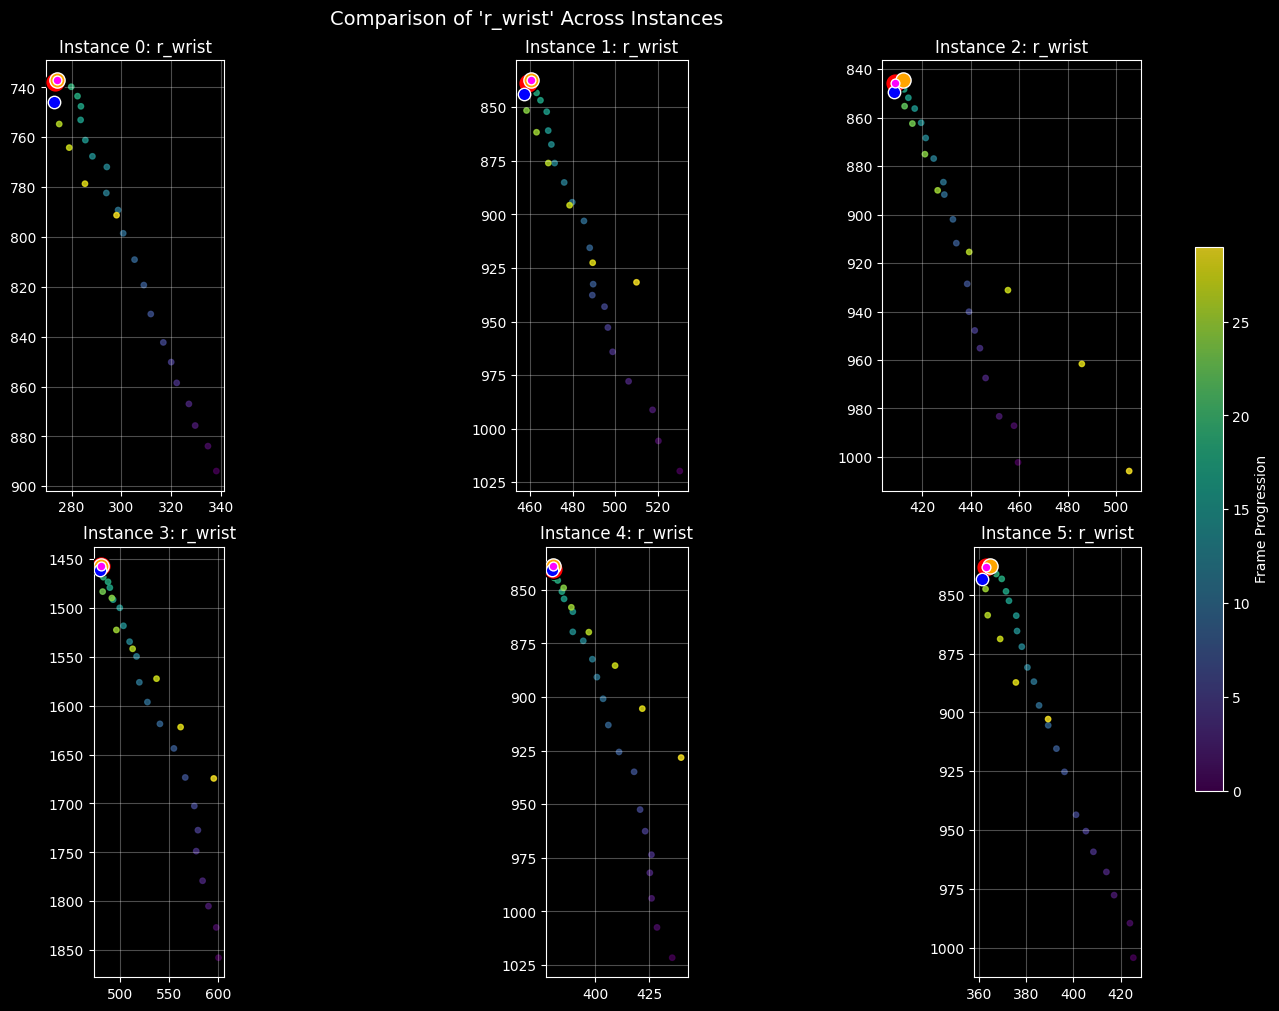

In [9]:
plot_feature_across_instances(top_backswing_SwExt_list,
                              feature_name='r_wrist',
                              highlight_frames_red=avg_backswing_idxs,
                              highlight_frames_orange=y_lowest,
                              highlight_frames_magenta=xy_lowest,
                              highlight_frames_eblue=x_lowest,
                              #highlight_frames_eblue=complex_backswing_top_frames,
                             )

In [56]:
top_backswing_df['top_backswing_idx'] = top_backswing_df.start_idx + np.array(avg_backswing_idxs) - 10

In [72]:
frames_list = []
for idx, row in top_backswing_df.iterrows():
    video_path = f"{row.pkl_path[:-3]}mp4"
    frames, fps = get_frames(video_path,
                            start_idx=row.top_backswing_idx - 66,
                             num_frames=96,
                             show_progress=False,
                             resize_dim=(512,512)
                            )
    frames_list.append(frames)

In [74]:
view_videos_grid(frames_list[3:])

## Lets find the contact frame

In [197]:
contact_df, contact_SwExt_list, contact_clip_names = get_cleaned_df(
    before_increment=-20,
    after_increment=40,
)
contact_frames_list = get_frames_from_df(contact_df)
print(set([x.shape for x in contact_frames_list]))
view_videos_grid(contact_frames_list[:3])

{(20, 512, 512, 3)}


In [198]:
x_highest = [get_x_highest(contact_SwExt_list[x].r_wrist) for x in range(len(contact_SwExt_list))]
y_highest = [get_y_highest(contact_SwExt_list[x].r_wrist) for x in range(len(contact_SwExt_list))]
xy_highest = [get_xy_sum_highest(contact_SwExt_list[x].r_wrist) for x in range(len(contact_SwExt_list))]
#complex_contact_bottom_frames = [get_top_idx(contact_SwExt_list[x].r_wrist, 
#                                 y_axis_only=True,
#                                 thresh_value=0.001) for x in range(len(contact_SwExt_list))]
contact_idxs = [x_highest, y_highest, xy_highest,]# complex_contact_bottom_frames]
avg_contact_idxs = list(np.array([np.array(x) for x in contact_idxs]).mean(axis=0).round().astype(int))
print(avg_contact_idxs)
print(y_highest)
print(xy_highest)
print(x_highest)

[7, 7, 10, 6, 7, 9]
[8, 8, 10, 6, 7, 10]
[7, 7, 10, 6, 7, 9]
[7, 6, 9, 5, 6, 9]


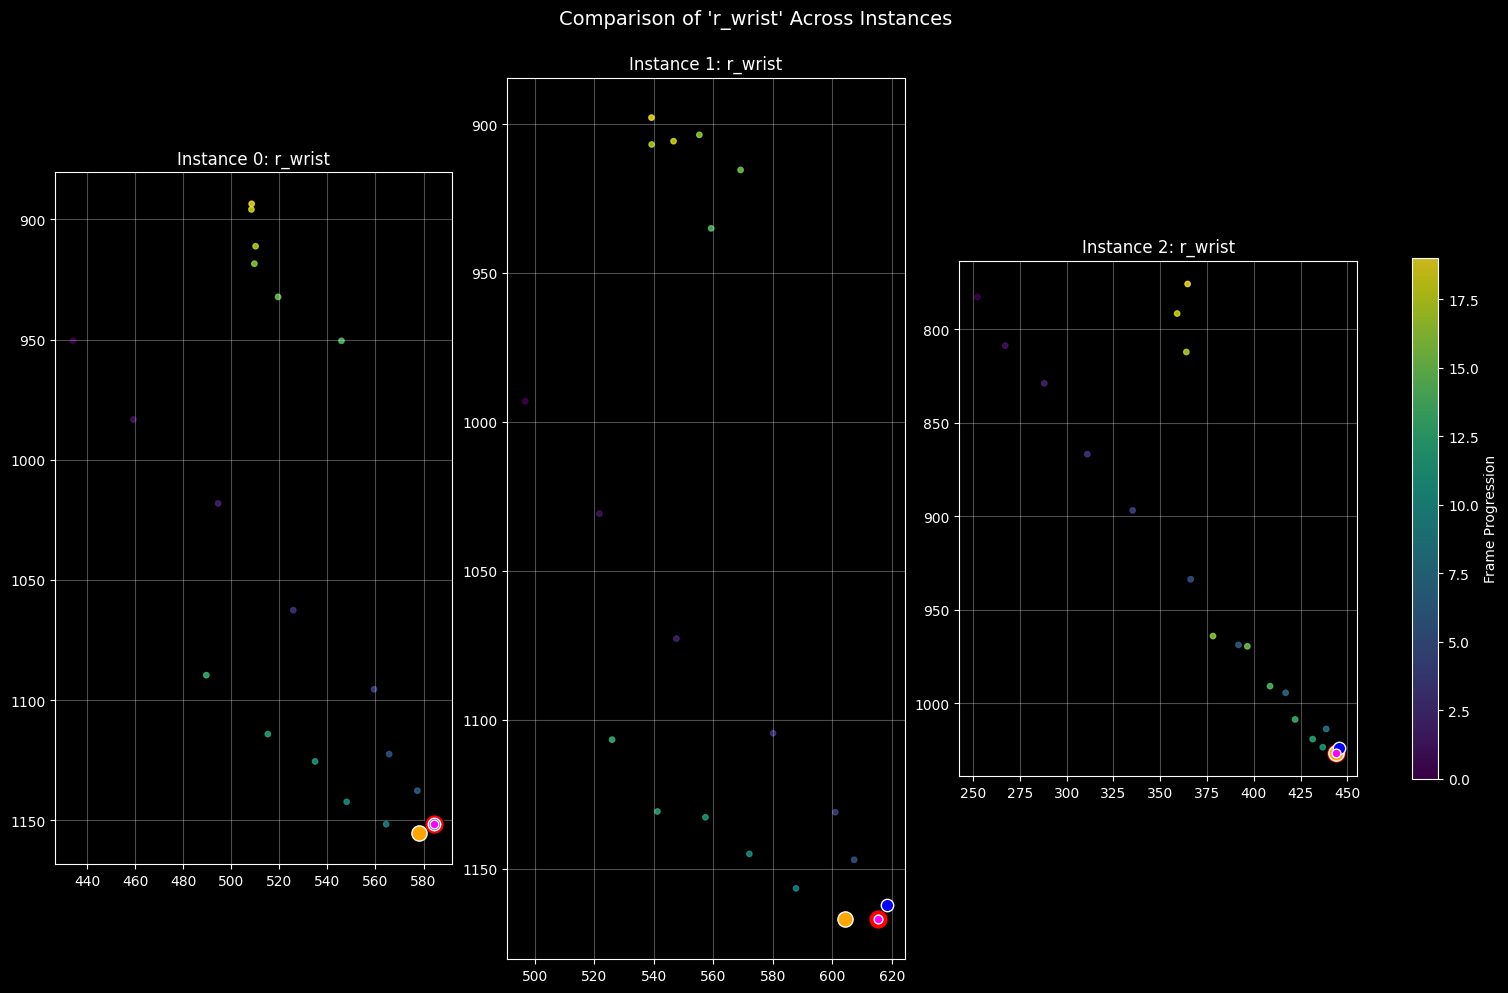

In [200]:
plot_feature_across_instances(contact_SwExt_list[:3],
                              feature_name='r_wrist',
                              highlight_frames_red=avg_contact_idxs,
                              highlight_frames_orange=y_highest,
                              highli ght_frames_magenta=xy_highest,
                              #highlight_frames_eblue=complex_contact_bottom_frames,
                              highlight_frames_eblue=x_highest,
                             )

## Now lets look at just top of backswing to contact

In [ ]:
complex_backswing_top_frames, highlight_frames

In [ ]:
# 20 frames before the first wrist over shoulder
top_frame = np.array(backswing_top_idxs) - 20
#top_frame = np.array(backswing_top_idxs) - 20
#bottom_frame = np.array(contact_idxs) + 20
bottom_frame = np.array(highlight_frames) + 20
bottom_frame - top_frame

In [ ]:
top_frame, bottom_frame

In [ ]:
frames_list = []
for idx, row in test_df.reset_index(drop=True).iterrows():
    video_path = f"{row.pkl_path[:-3]}mp4"
    frames, fps = get_frames(video_path,
                            start_idx=row.start_idx + top_frame[idx] - 20 ,
                             num_frames=bottom_frame[idx] - top_frame[idx] + 3,
                             show_progress=False,
                            )
    frames_list.append(frames)
view_videos_grid(frames_list)

## Lets find the start of the swings frame

In [14]:
start_df, start_SwExt_list, contact_clip_names = get_cleaned_df(
    before_increment=90,
    after_increment=0,
    return_kps=False
)
start_frames_list = get_frames_from_df(start_df)
print(set([x.shape for x in start_frames_list]))
view_videos_grid(start_frames_list)

{(90, 512, 512, 3)}


In [30]:
start_idxs = [30, 18, 24, 13, 25, 25]

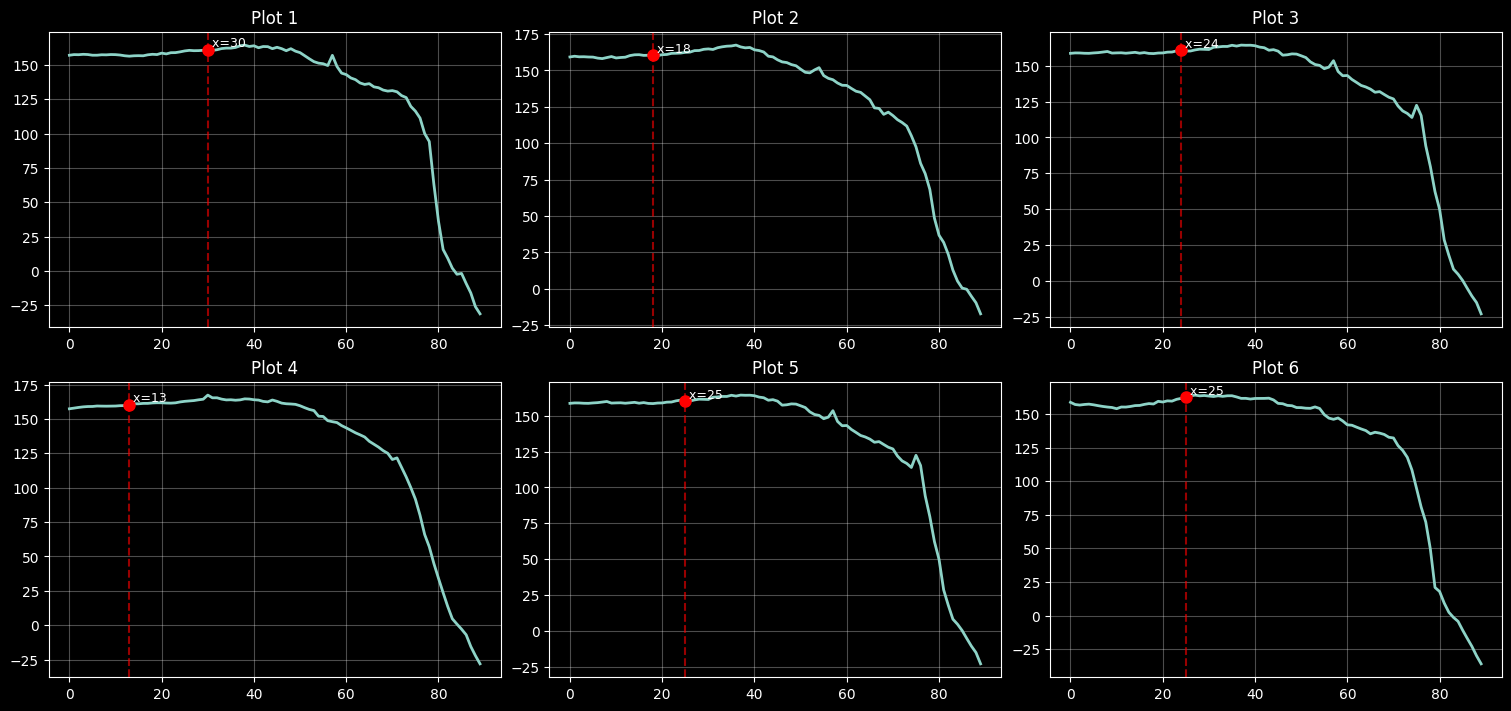

In [44]:
right_angle_list = [start_SwExt_list[x].right_arm_angle for x in range(len(start_SwExt_list))]
plot_grid_variable_markers(right_angle_list, start_idxs)

In [27]:
def plot_grid_variable_markers(data_list, marker_indices):
    """
    Plots a grid of lines where each plot highlights a specific, unique x-index.
    
    Args:
        data_list (list): List of arrays for y-values.
        marker_indices (list): List of x-indices, one for each plot. 
                               e.g., [12, 15, 10, ...]
    """
    n_plots = len(data_list)
    cols = 3
    rows = math.ceil(n_plots / cols)

    # Create figure with constrained layout
    fig, axes = plt.subplots(rows, cols, figsize=(15, 3.5 * rows), constrained_layout=True)
    
    # Flatten axes for single-loop iteration
    if n_plots > 1:
        axes = axes.flatten()
    else:
        axes = [axes]

    for i, ax in enumerate(axes):
        if i < n_plots:
            # 1. Get data
            y_data = data_list[i]
            x_data = np.arange(len(y_data))
            
            # 2. Get the specific marker for THIS plot
            # (Check bounds to ensure we have a marker for this plot index)
            if i < len(marker_indices):
                marker_idx = marker_indices[i]
            else:
                marker_idx = None

            # 3. Plot Line
            ax.plot(x_data, y_data, linewidth=2, label=f'Series {i}')

            # 4. Highlight the variable marker
            if marker_idx is not None and 0 <= marker_idx < len(y_data):
                # Vertical line
                ax.axvline(x=marker_idx, color='red', linestyle='--', alpha=0.6)
                # Point marker
                ax.plot(marker_idx, y_data[marker_idx], 'ro', markersize=8)
                # Optional: Label the frame number
                ax.text(marker_idx, y_data[marker_idx], f' x={marker_idx}', 
                        verticalalignment='bottom', fontsize=9)

            ax.set_title(f"Plot {i+1}")
            ax.grid(True, alpha=0.3)
        else:
            # Hide unused subplots
            ax.axis('off')

    plt.show()

In [ ]:
plot_feature_trajectories(